In [23]:
%load_ext autoreload
%autoreload 2

In [32]:
import spacy
import pandas as pd
from pprint import pprint
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import re
import plotly.express as px
from spacy import displacy
from spacy.symbols import NOUN, DET, ADJ


In [37]:
nlp  = spacy.load('nl_core_news_lg') 

In [35]:
df = pd.read_pickle('./data/processed/df_wiki_text.pickle')

In [33]:
def pre_process_text_generator(text_list):
    
    cleanr = re.compile('<.*?>')
    for text in text_list:
        if isinstance(text, str):
            text = text.lower()                 # Converting to lowercase

            text = re.sub(cleanr, ' ', text)                 # Removing HTML tags
            text = re.sub(r'[?|!|\'|"|#]',r'',text)
            text = re.sub(r'[.|,|)|(|\|/]',r' ',text)        # Removing Punctuations

            yield text
        


In [36]:
def extract_de_of_het(doc):
    substantieven = []
 
    for token in doc:

    #     print(token.text, token.dep_, token.head.text, token.head.pos_,
    #             [child for child in token.children])


        if token.pos == NOUN:
            # Case 1 : If there is het of de in the POS then extract the head text
    #         print(token.text, token.dep_, token.head.text, token.head.pos_,
    #             [child for child in token.children])


            # Case 2 : There is no clear DET. There must be some ADJ before the noun.

            # if the last letter of the adjective is 'e' and  then DET is always de
            children = [child for child in token.children]
            has_adjective = any([child.pos == ADJ for child in token.children])
            has_det = any([child.pos == DET for child in token.children])
            has_de_of_het = any([child.lemma_ == 'de' or  child.lemma_ == 'het' for child in token.children])
            has_geen_of_een = any([child.lemma_ == 'geen' or  child.lemma_ == 'een' for child in token.children])
            if has_adjective or has_det:
                found_adj_with_last_letter_e=False

                if not has_de_of_het and has_adjective and has_geen_of_een:

                    for child in children:
                        if child.pos == ADJ:
                            if child.text[-1] == 'e':
                                substantieven.append(  
                                    {'det': 'de',
                                     'woord' : token.text,
                                     'woord_vec':token.vector
                                    } )
                                found_adj_with_last_letter_e=True
                                break
                    if not found_adj_with_last_letter_e:

                        substantieven.append( {'det': 'het','woord' : token.text,'woord_vec':token.vector} )
#                     print(f"Token text  {token.text}")     
#                     print(f"Token children  {children}")     
#                     print(f"Found adjective ending with 'e' :{found_adj_with_last_letter_e}" )

                if has_de_of_het and not has_geen_of_een :

                    for child in children:
                        if child.pos == DET:
                            substantieven.append( {'det': child.lemma_,'woord' : token.text,'woord_vec':token.vector} )
                            break

        
                
    
    return substantieven



    #         if token.lemma_[-1] == 'e': 
    #             substantieven.append({'det': 'het','woord' : token.head.lemma_})
    #         else : # Else it is a de woord
    #             substantieven.append({'det': 'de','woord' : token.head.lemma_})


In [32]:
cleaned_text = pre_process_text_generator(df.text.tolist())

substantieven_doc_wise = []
with nlp.disable_pipes(["ner"]):
    docs = nlp.pipe(cleaned_text,n_process=5)
    print(f"Using pipeline : {nlp.pipe_names}")

    for doc in docs:
        lidwoordenlijst = extract_de_of_het(doc)
        substantieven_doc_wise.append(lidwoordenlijst)



Using pipeline : ['tagger', 'parser']


In [33]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [34]:
len(substantieven_doc_wise)

3051

In [46]:
df_processed = pd.DataFrame.from_dict(flatten(substantieven_doc_wise))

In [44]:
df_processed.head()

det      woord                                          woord_vec
0   de   gemeente  [1.0568, -0.94515, 0.99421, -0.68407, 2.9815, ...
1   de  provincie  [1.716, -1.4213, -0.50323, -2.4624, 1.5628, 0....
2  het       dorp  [1.9532, 0.047137, -0.70945, -2.8567, -0.33987...
3  het       dorp  [1.9532, 0.047137, -0.70945, -2.8567, -0.33987...
4   de       eeuw  [5.555, -2.933, -2.232, -2.0864, 1.9924, 0.687...

In [48]:
# Remove duplicates from name
df_processed.drop_duplicates(subset='woord',inplace=True)

In [19]:
df_processed.to_pickle('./data/dumps/woorden_met_hetofde.pickle')


(23302, 8)

det      woord                                          woord_vec  \
0   de   gemeente  [1.0568, -0.94515, 0.99421, -0.68407, 2.9815, ...   
1   de  provincie  [1.716, -1.4213, -0.50323, -2.4624, 1.5628, 0....   
2  het       dorp  [1.9532, 0.047137, -0.70945, -2.8567, -0.33987...   
4   de       eeuw  [5.555, -2.933, -2.232, -2.0864, 1.9924, 0.687...   
7  het     moment  [1.7155, 1.0782, 1.4089, -2.5729, 0.50998, -1....   

   2d_tsnse_x  2d_tsnse_y  3d_tsnse_x  3d_tsnse_y  3d_tsnse_z  
0   17.886803 -109.494179    8.696596    4.315295   -8.182873  
1   85.504738  -53.128902   -0.691837   12.283213   -2.905879  
2   82.390869  -41.150593   -5.146375   10.039696   -4.603694  
4  -55.283062  -59.481743    1.511579   -3.374212   -0.988650  
7  -46.525166  -65.703644    2.505650   -2.254646    2.607251

KeyboardInterrupt: 

det      woord                                          woord_vec  \
0   de   gemeente  [1.0568, -0.94515, 0.99421, -0.68407, 2.9815, ...   
1   de  provincie  [1.716, -1.4213, -0.50323, -2.4624, 1.5628, 0....   
2  het       dorp  [1.9532, 0.047137, -0.70945, -2.8567, -0.33987...   
4   de       eeuw  [5.555, -2.933, -2.232, -2.0864, 1.9924, 0.687...   
7  het     moment  [1.7155, 1.0782, 1.4089, -2.5729, 0.50998, -1....   

   2d_tsnse_x  2d_tsnse_y  3d_tsnse_x  3d_tsnse_y  3d_tsnse_z  
0   17.886803 -109.494179    8.696596    4.315295   -8.182873  
1   85.504738  -53.128902   -0.691837   12.283213   -2.905879  
2   82.390869  -41.150593   -5.146375   10.039696   -4.603694  
4  -55.283062  -59.481743    1.511579   -3.374212   -0.988650  
7  -46.525166  -65.703644    2.505650   -2.254646    2.607251

In [89]:
#df_processed.to_pickle('woorden_met_hetofde.pickle')
df_processed.to_pickle('./woorden_met_hetofde_tsne_2d_perplexity_50.pickle')

In [86]:
df_processed.det.value_counts()/df_processed.shape[0]

de           0.754399
het          0.244485
meer         0.000215
deze         0.000172
al           0.000172
die          0.000086
dat          0.000043
53%          0.000043
m            0.000043
1809-1811    0.000043
a8           0.000043
b            0.000043
c2000        0.000043
1918-1933    0.000043
ub40         0.000043
dezelfde     0.000043
dit          0.000043
Name: det, dtype: float64

In [9]:
df_only_de_en_het = df_processed[df_processed.det.isin(['de','het'])]

In [18]:
fig = px.scatter(df_only_de_en_het, x='2d_tsnse_x',
                 y='2d_tsnse_y', hover_data={'2d_tsnse_x':False, 'woord':True, 'det' : False, '2d_tsnse_y':False}, color='det',width=1200, height=1000)
fig.update_layout(
    
        
    title={
        'text': "TSNE projection of the words",
        'xanchor': 'center',
         'x':0.5,
        'yanchor': 'top'
    },
    legend_title_text="De/Het color",
    xaxis_title="1st component",
    yaxis_title="2nd component",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

# fig.update_traces(hovertemplate='{name}') # 
fig.write_html("../samarpan-rai.github.io/_includes/2d_tsne_woorden_distributie.html",config = {'responsive': True})

In [ ]:
# Add the TSNE normed cordinates 

In [65]:
tsne_model = TSNE(perplexity=50, n_jobs=5, n_components=3, init='pca', n_iter=500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

In [66]:
x = new_values[:,0]
y = new_values[:,1]
z = new_values[:,2]
df_processed['3d_tsnse_x'] = x
df_processed['3d_tsnse_y'] = y
df_processed['3d_tsnse_z'] = z
df_processed.head()

det      woord                                          woord_vec  \
0   de   gemeente  [1.0568, -0.94515, 0.99421, -0.68407, 2.9815, ...   
1   de  provincie  [1.716, -1.4213, -0.50323, -2.4624, 1.5628, 0....   
2  het       dorp  [1.9532, 0.047137, -0.70945, -2.8567, -0.33987...   
4   de       eeuw  [5.555, -2.933, -2.232, -2.0864, 1.9924, 0.687...   
7  het     moment  [1.7155, 1.0782, 1.4089, -2.5729, 0.50998, -1....   

   2d_tsnse_x  2d_tsnse_y  3d_tsnse_x  3d_tsnse_y  3d_tsnse_z  
0   15.682552 -102.061295    8.696596    4.315295   -8.182873  
1  -94.038322  -28.492416   -0.691837   12.283213   -2.905879  
2  -98.274948  -15.128893   -5.146375   10.039696   -4.603694  
4    8.719149  -15.469766    1.511579   -3.374212   -0.988650  
7  -11.333460  -32.988426    2.505650   -2.254646    2.607251

In [73]:
df_processed.to_pickle('./woorden_met_hetofde_tsne_2d_and_3d.pickle')

In [78]:
df_only_de_en_het = df_processed[df_processed.det.isin(['de','het'])]

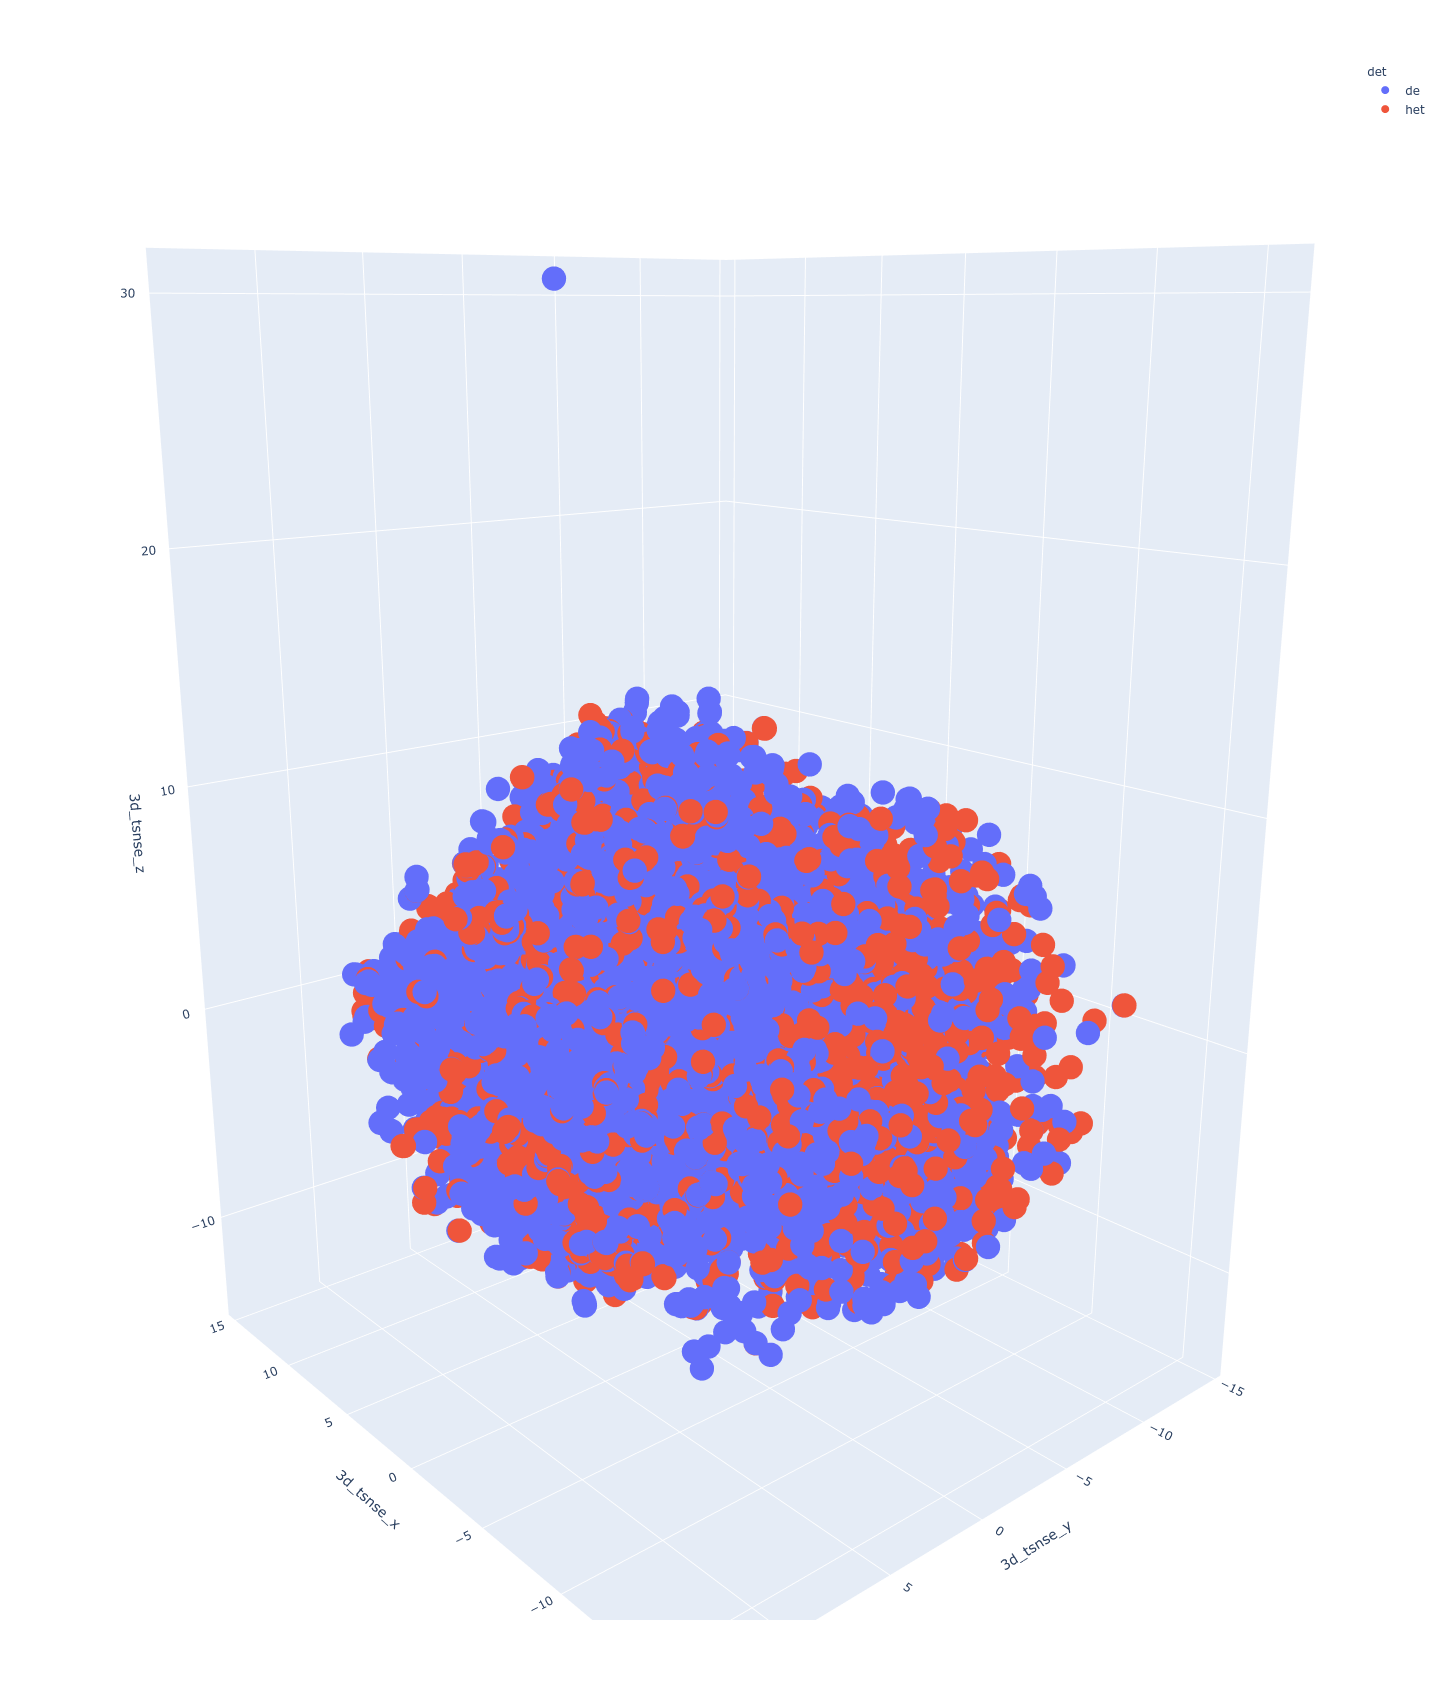

In [79]:
fig = px.scatter_3d(df_only_de_en_het, x='3d_tsnse_x', y='3d_tsnse_y', z='3d_tsnse_z',hover_data={'2d_tsnse_x':False, 
                                                                                          '2d_tsnse_y':False,
                                                                                          '3d_tsnse_x':False, 
                                                                                          '3d_tsnse_y':False,
                                                                                          '3d_tsnse_z':False,
                                                                                          'woord':True, 
                                                                                          'det' : True, 
                                                                                          '2d_tsnse_y':False}, color='det',width=1500, height=1700)
# fig.update_traces(hovertemplate='{name}') # 
fig.show()